In [3]:
import os
import sys
sys.path.append("./..")
from utils import PROJECT_ROOT
from definitions import get_cell_phenotype_id
import numpy as np
from SoftWL import compute_cluster_centroids, merge_close_clusters
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import pairwise_distances

In [4]:
iteration = 2
PhenoGraoh_k =  200
node_label = 'CellType'

In [5]:
# Retrive cluster data
FILE_NAMES = os.listdir(
    os.path.join(PROJECT_ROOT, "Output", "b_Soft_WL_Kernel_random_split", "Danenberg", "Subset_1", 'Subtrees')
)
X = []
Cluster_identities = []
for file_name in FILE_NAMES:
    x = np.load(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Danenberg",
            "Subset_1",
            "Subtrees",
            file_name,
            "neighborhood_aggregation",
            node_label,
            "X" + str(iteration) + ".npy",
        )
    )
    cluster_identities = np.load(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Danenberg",
            "Subset_1",
            "Subtrees",
            file_name,
            "pattern_ids",
            node_label,
            "pattern_id_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraoh_k)
            + ".npy",
        )
    )
    X.append(x)
    Cluster_identities.append(cluster_identities)
X = np.concatenate(X, axis=0)
Cluster_identities = np.concatenate(Cluster_identities, axis=0)


In [6]:
Centroids = compute_cluster_centroids(X, Cluster_identities)
Signature = Centroids.T


### Map patterns into categorical

In [15]:
import phenograph
Cluster_identities, _, _ = phenograph.cluster(Signature, k= 30)
Cluster_identities

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.1389598846435547 seconds
Jaccard graph constructed in 0.609621524810791 seconds
Wrote graph to binary file in 0.0025746822357177734 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.00791734
Louvain completed 21 runs in 0.49114346504211426 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 1.8915231227874756 seconds


array([-1, -1, -1,  0, -1,  0,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0, -1])

### Signature map 

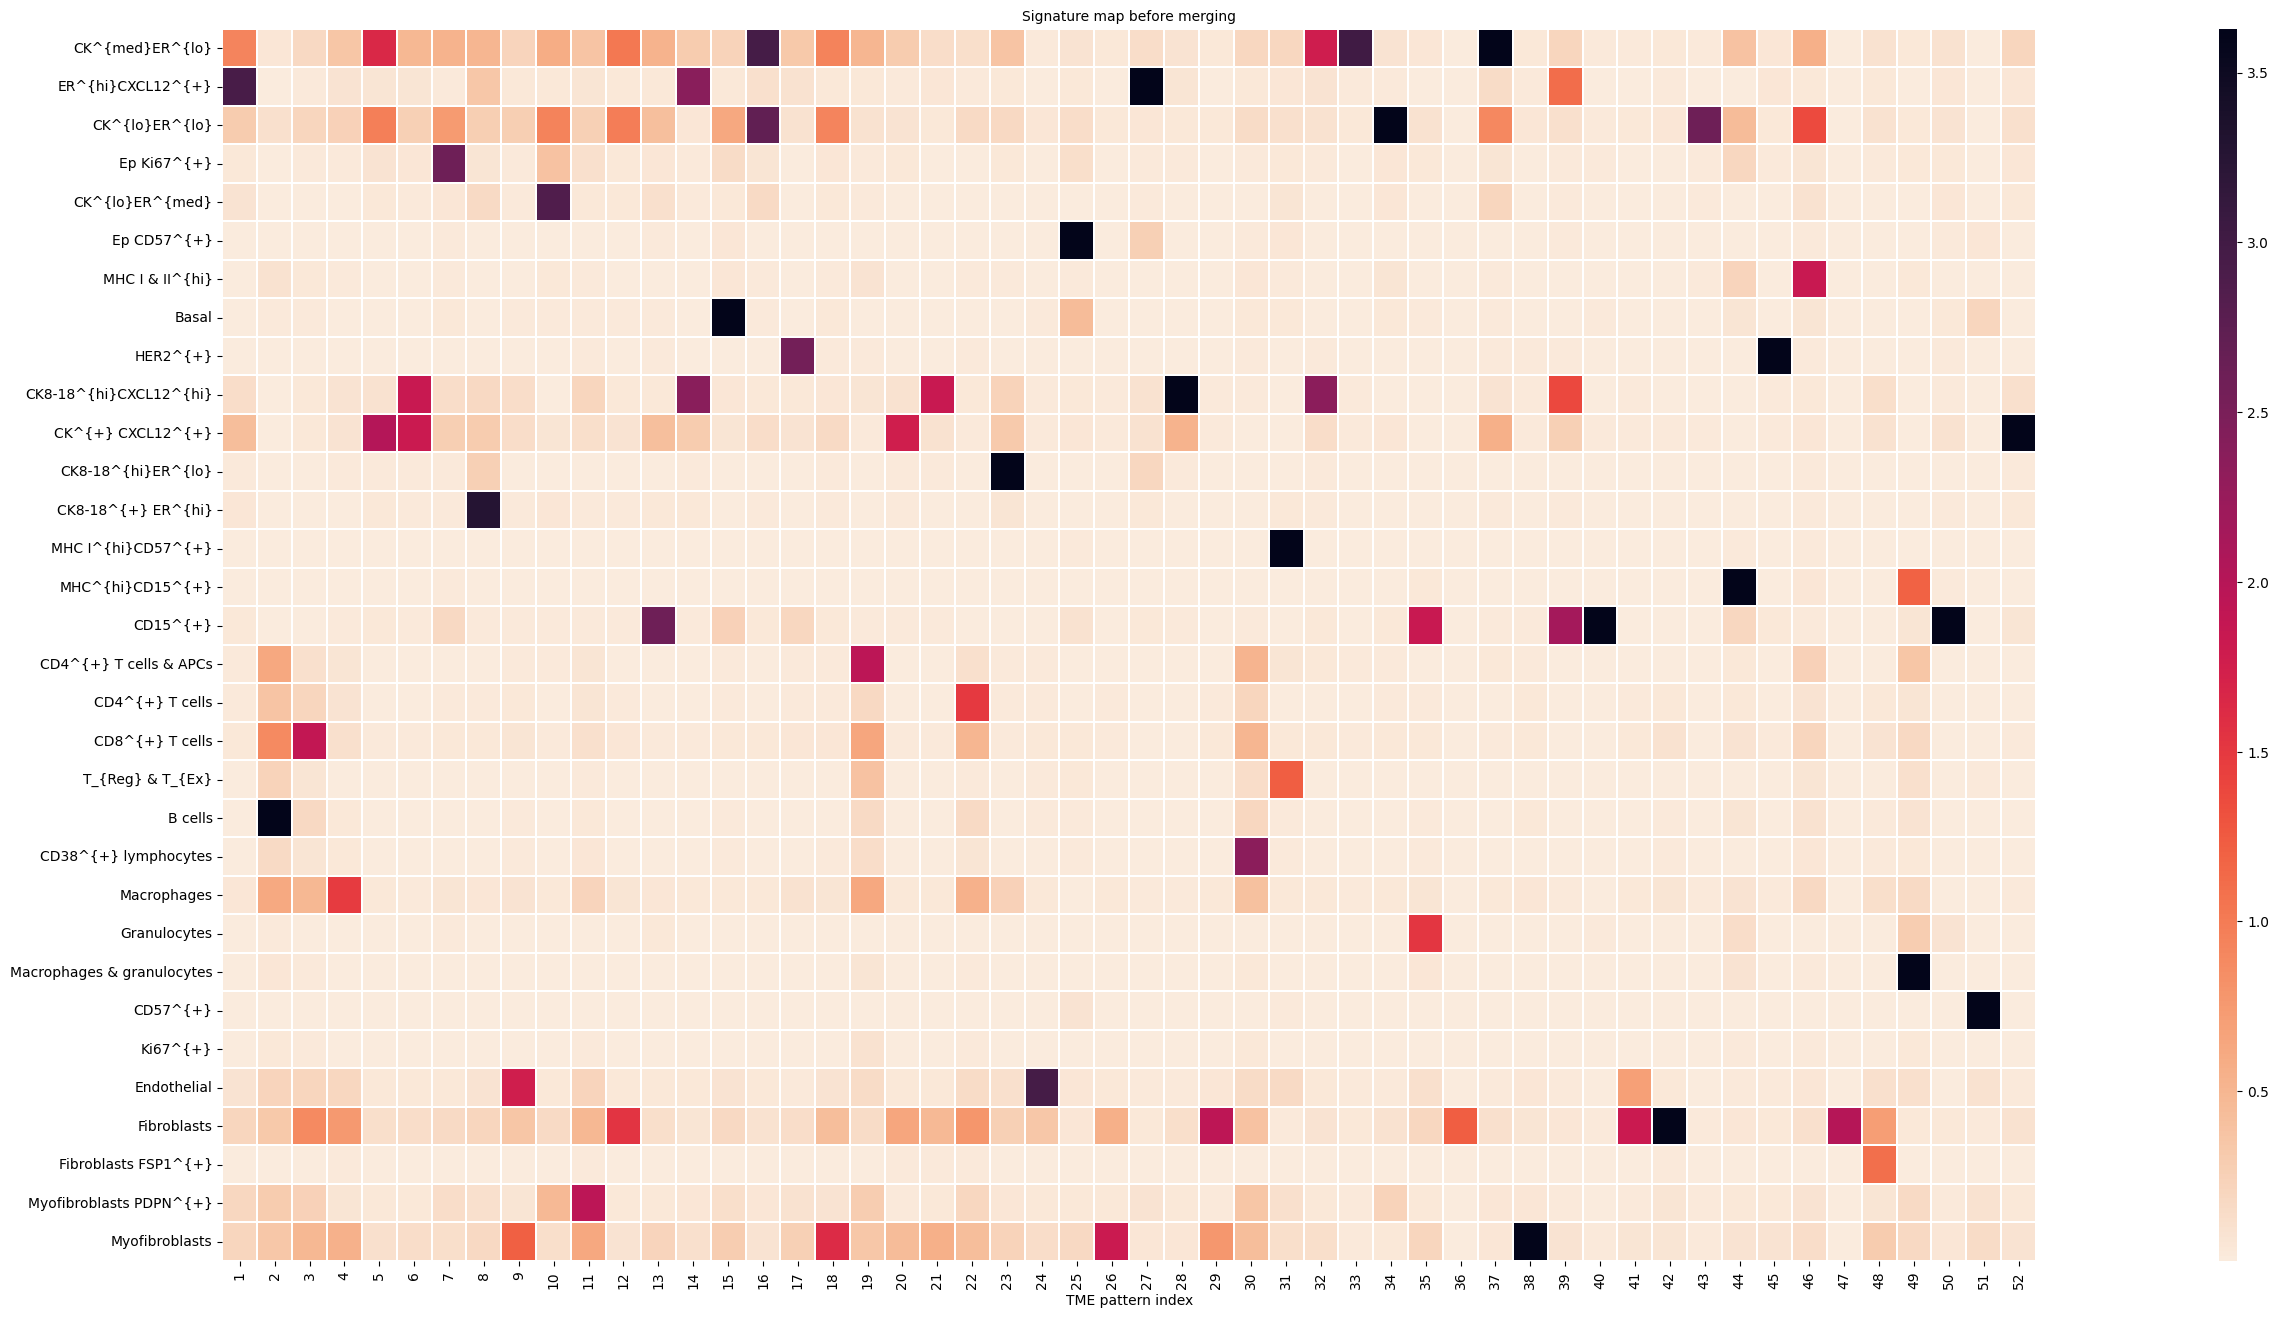

In [7]:
# Signature map before merging
Centroids = compute_cluster_centroids(X, Cluster_identities)
Signature = Centroids.T
if node_label == 'CellType':
    Node_label_list = list(get_cell_phenotype_id('Danenberg'))
else:
    Node_label_list = ['tumor', 'immune', 'stroma']

f, (ax, cbar_ax) = plt.subplots(1,2,figsize=(Signature.shape[1]*0.5, Signature.shape[0]*0.5, ),gridspec_kw= {"width_ratios": [20,0.2]} )
sns.heatmap(
        Signature,
        ax=ax,
        cbar_ax=cbar_ax,
        cmap="rocket_r",
        linewidth=0.005,
        edgecolor="black",
        vmax=np.percentile(Signature, 99),
        vmin=np.percentile(Signature, 1),
    )
ax.set_yticklabels(Node_label_list, rotation=0, fontsize=10)
ax.set_xticklabels([i+1 for i in range(Signature.shape[1])], fontsize=10, rotation = 90)
ax.set_xlabel("TME pattern index", fontsize=10)
ax.set_title("Signature map before merging", fontsize=10)
plt.show()


### Umap

In [7]:
# Umap before merging
from sklearn.manifold import TSNE
import umap.umap_ as umap

n_sample = 100000
indices_sampled = np.random.choice(X.shape[0], n_sample, replace=False)
X_sampled = X[indices_sampled]
Cluster_identities_sampled = Cluster_identities[indices_sampled]
reducer = umap.UMAP()
embedding = reducer.fit_transform(X_sampled-np.mean(X_sampled, axis=0))


/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/umap/distances.py:1086: 

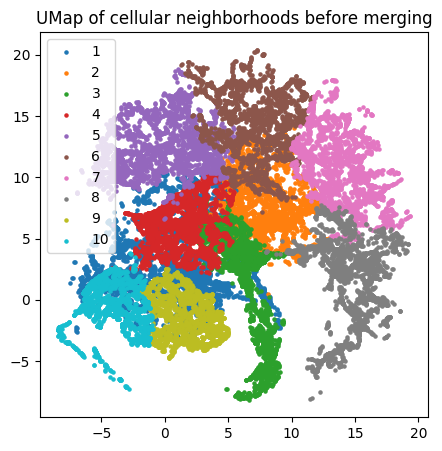

In [8]:
f, ax = plt.subplots(figsize = (5,5))
for i in range(10):
    ax.scatter(embedding[Cluster_identities_sampled == i,0], embedding[Cluster_identities_sampled == i,1], color = sns.color_palette('tab10')[i], s = 5, label = i+1)

ax.legend()
ax.set(title = 'UMap of cellular neighborhoods before merging')
f.show()

### Pairwose distance between centroids

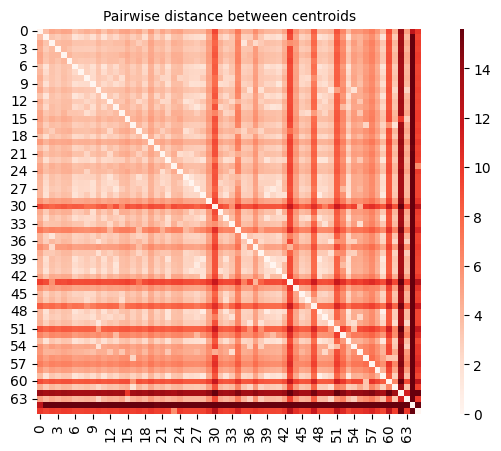

In [8]:
# Pirwise distance between centroids
pairwise_dist = pairwise_distances(Centroids)
f, (ax, cbar_ax) = plt.subplots(1,2,figsize=(5.5, 5),gridspec_kw= {"width_ratios": [20,0.2]} )
sns.heatmap(
        pairwise_dist,
        ax=ax,
        cbar_ax=cbar_ax,
        cmap="Reds",
        linewidth=0.0005,
        edgecolor="black",
        vmax=np.percentile(Centroids, 100),
        vmin=np.percentile(Centroids, 0),
    )
ax.set_title("Pairwise distance between centroids", fontsize=10)
plt.show()